# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.




#  Part 1: Main Focus 
Combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

- Inspect
- Clean
- Analyze

# Part 2: Main Focus 

Build a machine learning model to predict the accuracy of offers completed from the EDA of part 1. 

----

In [1]:
# Import Libraries 

# Regular EDA and plotting libraries 
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns

# Models and Evaluation 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Plot appears inside the ntebook 
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Moreover, some further information given about the offers is that there are 3 different offer types:
 - BOGO - buy one get one free
 - Discount - discount with purchase
 - Informational - provides information about products


# Read in Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

-----

# Part 1 

### 1. First Initial inspection of Data 

To get a better understanding of the data let's take a look at: 

- Info
- Shape
- Nested columns
- Data types
- Rows/columns
- Missing values 
- Duplicates
- Features 
- etc

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


- Channels column is nested. Better to normalize nested columns.

In [4]:
#Shape of dataframe 
portfolio.shape

(10, 6)

In [5]:
#Inspect data rows/columns
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


 - Data types are ok and match the values 
 - No missing values 
 
 *** If data was missing we would have to consider imputing(e.g. Mean, Mode, Median) or dropping rows/colummns without data if it doesn't dilute the data's accuracy. Or save missing values data and see if it can be useful to the end result of the project. 

In [6]:
# Check unique offers
portfolio.id.nunique()

10

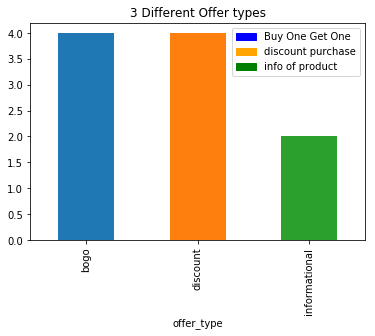

In [7]:
# Fiter the 3 different offer types count (should equal 10 in total)
portfolio.groupby('offer_type')['id'].count().plot(kind = 'bar', title = "3 Different Offer types")
colors = {'Buy One Get One':'blue', 'discount purchase':'orange', 'info of product': 'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels);

- BOGO - buy one get one free (4)
- Discount - discount with purchase(4)
- Informational - provides information about products(2)

In [8]:
#Normalize nested data / in case we need to use it later
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
channels_set

{'email', 'mobile', 'social', 'web'}

In [9]:
# assort the channels into different features
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [10]:
# Drop the 'channels' column 
portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


----

# Demographic Data 

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income


In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


- Missing values for income and gender 
- Data entry for age - 118 years old (not accurate) 

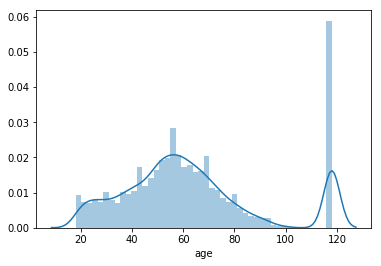

In [12]:
#Visualize the age distribution 
sns.distplot(profile['age']);

 - Age for 118 years old seems to be an outlier 
 - ages 20 and below is ok as teenagers are not coffee drinkers and least likely to complete offers or visit Starbucks to drink coffee. 

In [13]:
#Shape 
profile.shape

(17000, 5)

In [14]:
#Inspect data rows/columns
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


- datatypes are ok but maybe need to change later in data modeling (id is string)
- Missing values for gender/income

In [15]:
#Check amount of missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
#Check duplicates
profile.duplicated().sum()

0

 - We have a matching number of missing values for gender and income. This is good because we can most likely drop them and check if it keeps the data's accuracy.   

In [17]:
# Explore the missing data further
(profile[profile['age']==118].count())

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

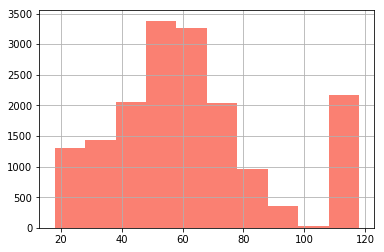

In [18]:
profile.age.hist(color='salmon');

- 2175 people aged 118 using the starbucks app is near to impossible. First thought, this data serves no purpose and can be removed.  Second thought, this could be a safe default setting used when a user skips the personal info section. Showing the data to be an outlier. 

*** (If this was a real project I would contact the business and speak with someone to verify what this data means and progress accordanly)

In [19]:
profile[['age', 'income', 'gender']][profile['age']==118].head()

,age,income,gender
0,118,NaN,None
2,118,NaN,None
4,118,NaN,None
6,118,NaN,None
7,118,NaN,None


In [20]:
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

-----

# Transactional records
The schema for the transactional data is as follows:
- transcript.json
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [21]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
# Shape 
transcript.shape

(306534, 4)

In [23]:
# Explore rows and columns
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


- No missing values 
- Data types are ok 

In [24]:
# Does the person column match the demographic columns for unique value counts of 17000?
transcript.person.nunique()

17000

- Combine the columns to gain more insightful data

In [25]:
# Concat columns
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)

In [26]:
transcript.head(5)

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


- Duplicates have appeared for value/offer_id.  Value column has a dictionary format 

In [27]:
transcript['value']

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16         {'offer id': '0b1e1539f2cc45b

__Better to drop the value column__

In [28]:
# filter keys in value column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

keys

['offer id', 'amount', 'offer_id', 'reward']

In [29]:
# put each key in seperated column.
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

### Data has  been inspected and cleaned 

Now that the data has been better understood. We can start to explore the data to answer the main focus:

__Combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.__

Questions to explore:
   
- What demographic best responds to these offer types? 
   1. Age 
   2. Income
   3. Gender 
   
   
- What offers are most used?
   1. Percentage of offers completed
   2. Most common types of promotions 
 
 
 - Combine Demographic and offers for further analysis 


------

## Analyzing / Model the Data

We have already seen some demographic finding from the inspection and cleaning data phase. Let's recap on everything to complete the next phase. 

In [30]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568


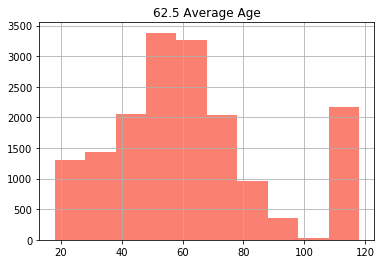

In [31]:
profile['age'].hist(color = 'salmon')
plt.title('62.5 Average Age');

In [32]:
profile['income'].mean()

65404.991568296799

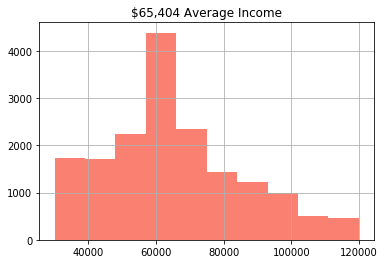

In [33]:
profile['income'].hist(color = 'salmon')
plt.title('$65,404 Average Income');

In [34]:
profile['gender'].value_counts()

M     8484
F     6129
NA    2175
O      212
Name: gender, dtype: int64

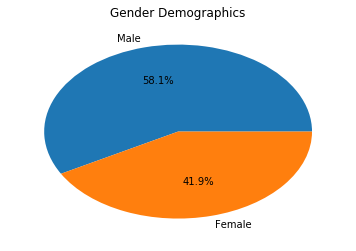

In [35]:
ratio = [8484, 6129]
labels = ['Male', 'Female']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.title('Gender Demographics')
plt.show()

__Overview of Demographic Data__

- 62.5 average age 
- $65,404 average
- 58.1% male customers / 41.9% Female customers

### Now we have a better understanding of the demographics. Let's see what promotions are most commonly completed by these Starbucks customers. 

In [36]:
#Total amount of transactions
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

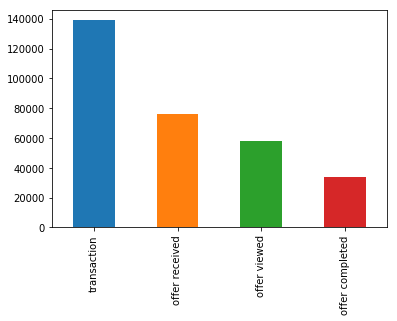

In [37]:
# Visualize Data 
transcript.event.value_counts().plot(kind = 'bar');

__Conclusion From Data__

- Starbucks sends out a lot more offers than what are completed. Only about 54% of those offers sent out are offer_recieved. 41% are offer_viewed and only 24% are offer_completed. 

In [74]:
# Perentage of offers completed
transaction = 138953
offer_completed = 33579

percentage_completed = offer_completed / transaction * 100
'the conversion rate of completed offers are {}%'.format(percentage_completed)


'the conversion rate of completed offers are 24.16572510129324%'

- We want to analyze the completed offers only

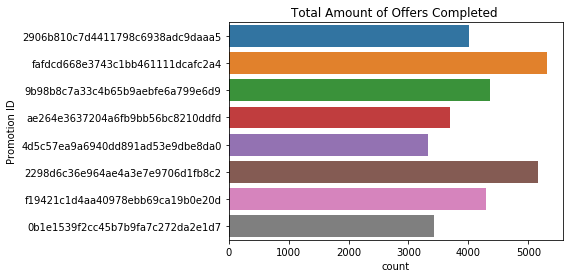

In [39]:
# Filter offers completed / Visualize data 
import seaborn as sns

offers_completed = transcript[transcript['event'] == 'offer completed']

sns.countplot(y=offers_completed['offer_id'])
plt.title('Total Amount of Offers Completed ')
plt.ylabel('Promotion ID')
plt.xticks()
plt.show();

__Within the 24% of offers completed: 2 promotion ID's stand out (Orange and Brown graph bars)__ 

- These two promotions each reached over 5,000 with completed offers. This information could be very useful for promotional research. 



----

## Within these offers completed what promotion was most offen completed? 



In [40]:
# Create a function for offer_types with offer_id to show the completed offers category 

def get_offer_type(offer_id):
    '''
    input: offer_id: id of offer
    
    output: offer type
    
    '''
    
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

In [41]:
# Total amount of offer types 
transcript[transcript['offer_type'] != 'NA']['offer_type'].value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

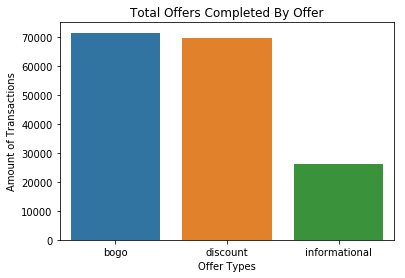

In [42]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Total Offers Completed By Offer')
plt.ylabel('Amount of Transactions')
plt.xlabel('Offer Types')
plt.xticks()
plt.show();

__Conclusion From Graph__
- bogo             71,617
- discount         69,898
- informational    26,066

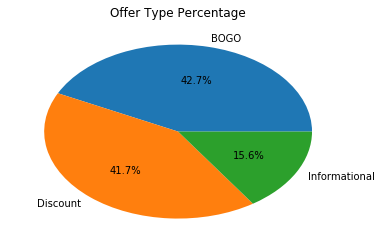

In [43]:
# Pie chart for percentage visuals
ratio = [71617, 69898, 26066]
labels = ['BOGO', 'Discount', 'Informational']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.title('Offer Type Percentage')
plt.show()

- 1st)BOGO has the highest percentage of 42.7%. 
- 2nd)Discount with 41.7% 
- 3rd)Informational with 15.6% 

-----

## Let's analyze the pattern from demographics and  promotions types 

- Is there a preferred promotion per age group? 
- Do male or females prefer a certain type of offer?
- Does income influence the use of promotions? 

In [44]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568


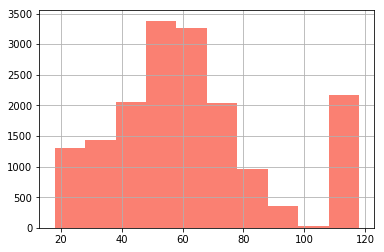

In [45]:
profile.age.hist(color = 'salmon');

In [46]:
profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

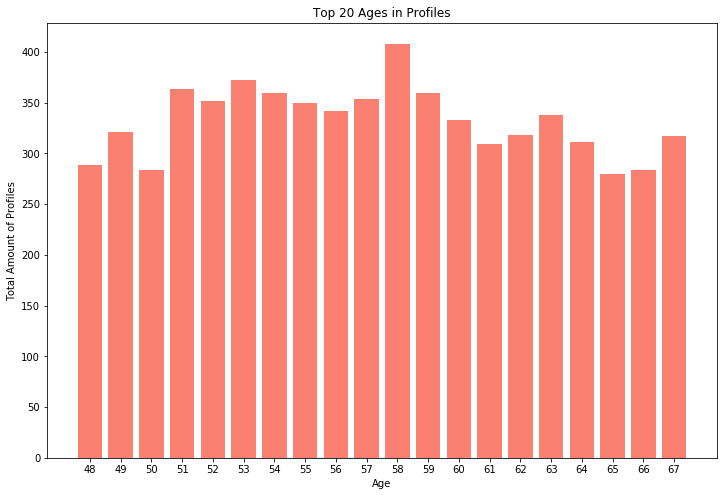

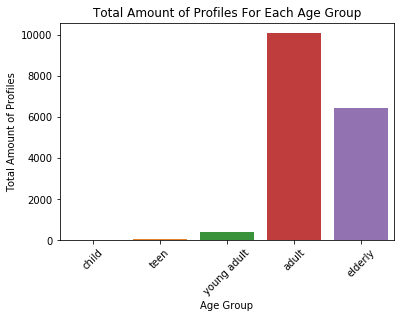

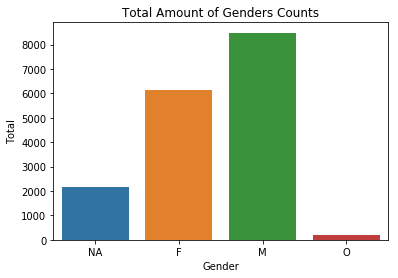

In [47]:
# Age 118 is not included
plt.figure(figsize=(12,8))
top20_ages = profile['age'].value_counts()[1:].head(20).reset_index()
plt.bar(top20_ages['index'], top20_ages['age'],color = 'salmon')
plt.title('Top 20 Ages in Profiles')
plt.ylabel('Total Amount of Profiles')
plt.xlabel('Age')
plt.xticks(top20_ages['index'], rotation = 0)
plt.show();

sns.countplot(x='age_groups', data=profile)
plt.title('Total Amount of Profiles For Each Age Group')
plt.ylabel('Total Amount of Profiles')
plt.xlabel('Age Group')
plt.xticks(rotation = 45)
plt.show();

sns.countplot(profile['gender'])
plt.title('Total Amount of Genders Counts')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [48]:
#Takes a while to load 
def get_customer_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_groups'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: get_customer_age_group(x['person']), axis=1)

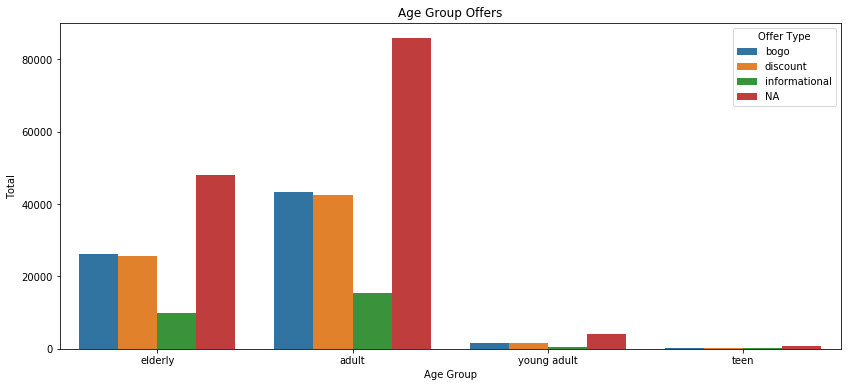

In [49]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group", hue="offer_type", data=transcript)
plt.title('Age Group Offers')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

__Conclusion from Data__

- The __adult__ age group has the highest response rate. Around 47,000 for BOGO and 45,000 for Discounted offer types.  

- The __elderly__ are the second most frequent users. Around 25,000 for BOGO and 23,000 for Discounted offer types.

This makes sense as the data shows __the average age of customers are aged 62.5 years old. Starbucks can be seens as a more expensive coffee shop__. Very few young adults and teenegers seek to go to starbucks for their coffee prefrence. 

I suspect the younger population like child and teenager that go to StarBucks may go with/go because their parents are frequent goers to Starbucks thus register with the app to also receive rewards. 


__My hypothesis:__

If we analyze the income and age, __I suspect that people with higher income (generally older poeple who have developed thier career) will be the the most frequent customers to starbucks.__ 



----

## Income vs Age Ranges

Let's get a more detailed age range for a better understanding of income and age.

In [50]:
profile.head()

,age,became_member_on,gender,id,income,age_groups
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,elderly
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,adult
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,elderly
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,elderly
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568,elderly


In [51]:
# Create age ranges 
age_range_labels = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_labels, right = False)
profile['age_range'] = pd.Categorical(profile['age_range'], ordered = True, categories = age_range_labels)
profile.sample(5)

,age,became_member_on,gender,id,income,age_groups,age_range
14123,66,20140312,M,fe3f369d2f49407caf10c1e193043760,54000.0,elderly,60-69
9392,76,20170222,M,92e13d9868b4414ab1aa3fe67f210bf4,64000.0,elderly,70-79
10799,57,20171026,M,eec23cb68c344d01b7a81e5b64177c1e,42000.0,adult,50-59
16151,56,20171018,M,aa17c64a79f343c3a8092244f4c7331c,49000.0,adult,50-59
12611,49,20160418,F,1da9869eff9c44cdbac2f1e4b9567df3,83000.0,adult,40-49


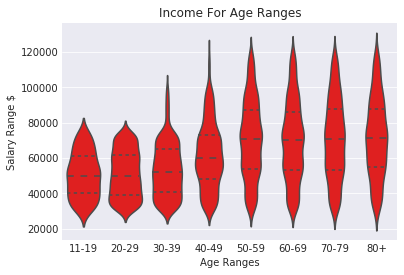

In [98]:
#Visiualizing the data with violin plot
sns.violinplot(data = profile, x = 'age_range', y = 'income', color = 'red', inner = 'quartile')
plt.title('Income For Age Ranges')
plt.xlabel('Age Ranges')
plt.ylabel('Salary Range $');

__Conclusion from Data__

Initial Hypothesis: I suspect that people with higher income (generally older poeple who have developed thier career) will be the the most frequent customers to starbucks.


- This to be mostly true as the ages 50-80+ have a higher average with an average income of $65,404. The data also showed older age ranges to complete the most offers. 



- On the lower scale we have ages 11-39. These age group correlate to lower reward offers and less offers completed.

# Income and Gender 

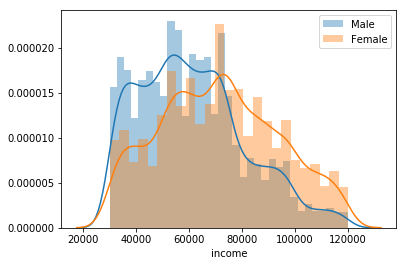

In [53]:
#Income for Male and Female 
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

__Conclusion From Data__
 

- From 30,000 to 60,000 females have a lower income. 

- From 80,000 to 120,000 females have a higher income. 

** Females tend to live longer than males and can have an impact on older age ranges like 80+ years old. 
** Amount in $US

# Does income range have an impact on offers completed ?

-----

# Are these promotions offer types favored by a particular gender?

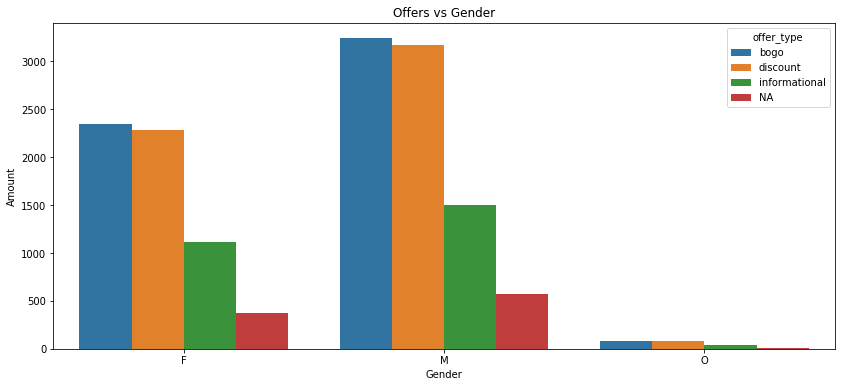

In [54]:
#Visualize data
plt.figure(figsize=(14, 6))
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'], hue = 'offer_type', data=transcript)
plt.title('Offers vs Gender')
plt.ylabel('Amount')
plt.xlabel('Gender')
plt.xticks()
plt.show();

# Part 1 Completed : Recap of Key Data 


### Out of the three offer types the most popular are:

Offer type
- BOGO with 42.7%
- Discounted 41.7%
- Informational 15.6% 

Gender 

- Males make up 58.1% of offers completed 
- Females make up 41.9% of offers completed 


Gender and Offer

- Males complete more offers at Starbucks 
   -  BOGO with 3500
   -  Discounted 3300
   -  Informational 1600 
   
   
- Females competed these offers 
   -  BOGO with 2400
   -  Discounted 2200
   -  Informational 1200  

Income in $ 

- People with a higher income tend to complete more offers average 62,404. 

- From 30,000 to 60,000 females have a lower income.
- From 80,000 to 120,000 females have a higher income.
 
 Age 
 
- The average age is 62.5 years old 
- Top 20 ages are from 47 - 67 years old 
 
Income and Age 
 
- Ages for adults around 55-65 with an income of the average $62,404 completed the most offers 


----

# Part 2 

# Modeling Data - Response to an Offer (Logistic Regression)


We have a better understanding of the demographics and what offers are completed. Let's build a model that predicts whether people will respond to an offer or not. 


__Problem Definition__

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

__Evaluation__

With this type of classification outcome we need to rely on accuracy to be our indicator of success. If we can reach 90% accuracy at predicting whether or not a person will complete am offer we well pursue the project. 


__Features__

We have to look at what features and target would be best to model the data with. As we are looking to combine demographics and offer types:

Some features to consider 
- event: (string) offer received, offer viewed, transaction, offer completed 
- person: (string/hash)
- offer id: (string/hash) not associated with any "transaction"
- amount: (numeric) money spent in "transaction"
- reward: (numeric) money gained from "offer completed" 
- offer_type: (string) bogo, discount, informational
- age: (numeric) missing value encoded as 118 
- gender: (categorical) M, F, O, or null
- income: (numeric)


__Approach:__

Combine all data together to get access to the features. Prioritize oferr_type as the target into the model as we are focusing on what offers are completed with the demographic variations as features. 

ML Models we can use to test the accuracy:

- Logistic Regression 
- KneighborsClassifier 
- RandomForest 

In [55]:
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward,offer_type,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,bogo,elderly
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,discount,elderly
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,2906b810c7d4411798c6938adc9daaa5,0,discount,elderly
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,fafdcd668e3743c1bb461111dcafc2a4,0,discount,elderly
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,bogo,elderly


- age_group needs to be a int 
- Offer_type needs to be an int 

- Income and gender need to be added (not as string)

- Offer type needs to be changed to int

In [56]:
# Remove offer id 
del transcript['offer id']

### Add in Income and Gender


note** took a while to process 

In [57]:
# Get customer income 
def get_customer_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: get_customer_income(x['person']), axis=1)

In [58]:
# Get Customer gender
def get_customer_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: get_customer_gender(x['person']), axis=1)

In [59]:
transcript = transcript[transcript['offer_id'] != 'NA']

In [60]:
transcript.head()

,event,person,time,value,amount,offer_id,reward,offer_type,age_group,income,gender
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,bogo,elderly,100000.000000,F
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,discount,elderly,65404.991568,NA
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,discount,elderly,70000.000000,M
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,discount,elderly,65404.991568,NA
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,bogo,elderly,65404.991568,NA


In [61]:
# convert to category / add tolist 

#event
labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}

#offer_id
labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}

#age_group
labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}

#gender
labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'adult': 1, 'elderly': 2, 'teen': 3, 'young adult': 4}}
{'gender': {'F': 1, 'M': 2, 'NA': 3, 'O': 4}}


In [63]:
labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}

{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [64]:
#Replace categorical with numerical
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)
transcript.replace(replace_map_comp_offer_type, inplace=True)


In [65]:
transcript.head()

,event,person,time,value,amount,offer_id,reward,offer_type,age_group,income,gender
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,8,0,2,2,100000.000000,1
1,2,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,2,0,3,2,65404.991568,3
2,2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,4,0,3,2,70000.000000,2
3,2,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,11,0,3,2,65404.991568,3
4,2,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,6,0,2,2,65404.991568,3


- Income column has way to many decimal points. We need to change it to .2F format  

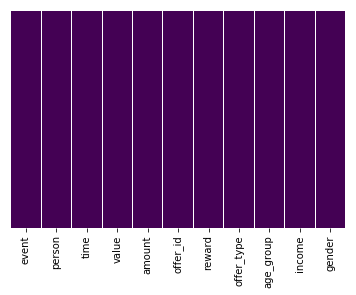

In [66]:
# Check missing values again just incase I forgot something 
sns.heatmap(transcript.isnull(), yticklabels=False, cbar=False,cmap='viridis');

- No missing values 

In [67]:
# Create Target and Features to split data / drop unnecessary features 
target = transcript['offer_type']
features = transcript.drop(['person', 'offer_type', 'value'], axis = 1)

In [68]:
# normalize time, amount, reward, income 
scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,amount,offer_id,reward,age_group,income,gender
0,2,0.0,0.0,8,0.0,2,0.777778,1
1,2,0.0,0.0,2,0.0,2,0.393389,3
2,2,0.0,0.0,4,0.0,2,0.444444,2
3,2,0.0,0.0,11,0.0,2,0.393389,3
4,2,0.0,0.0,6,0.0,2,0.393389,3


- Data is ready to be used for ML model 

-----

### I want to test 3 models and see which one gives us the best results. I will use a function that test all three models and fine tune them if they fall short of the 90% accuracy rate.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [82]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [83]:
model_scores = fit_and_score(models=models,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)

model_scores

{'Logistic Regression': 0.80566067280841402,
 'KNN': 1.0,
 'Random Forest': 0.99997390192342828}

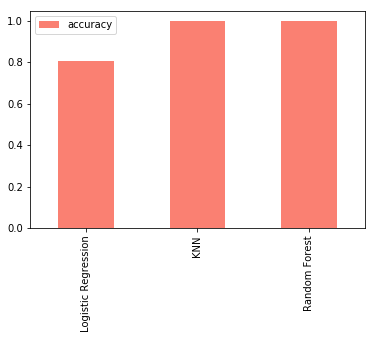

In [84]:
#Visualize compare models
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar(color = 'salmon');

### Wow great results from KNN and Random Forest. These two models could be used to give us the accuracy we were looking for in this project (90% or above). The logistic Regression Model fell short but with some hyperparamter tuning maybe it can be increased to 90% or above.

# Tune Logisctic Regresison Model 

The Logistic Regression Model is really effecient at calculating classification outcomes. As we converted the data to a number range it would be best to tune the Logistic Model and use that if it can return a accuracy of 90% or higher. 

In [85]:
# Create a hyperparamater grid for the LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
               "solver": ["liblinear"]}

In [86]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

np.random.seed(42)

# Setup Random hyperparameter

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                 param_distributions=log_reg_grid,
                                 cv=2,
                                 n_iter=20,
                                 verbose=True)

# Fit random hyper parameter fro Logistic Regression

rs_log_reg.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  9.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'C': array([  1.00000e-04,   2.63665e-04,   6.95193e-04,   1.83298e-03,
         4.83293e-03,   1.27427e-02,   3.35982e-02,   8.85867e-02,
         2.33572e-01,   6.15848e-01,   1.62378e+00,   4.28133e+00,
         1.12884e+01,   2.97635e+01,   7.84760e+01,   2.06914e+02,
         5.45559e+02,   1.43845e+03,   3.79269e+03,   1.00000e+04]), 'solver': ['liblinear']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=True)

## Note For CV = 2

- __I orginally used cv=5 for better practices__, but my computer is really slow and it took a long time to process. I changed it down to cv=2 for performance purposes as that took 4.5 minutes to process. Anyway, the result was the same of 0.012742749857031334. 

In [87]:
# Evaluate the randomized search RandomForestClassifier Model 
rs_log_reg.score(X_test, y_test)

0.81547354959939455

In [88]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.012742749857031334}

 - Only a 1.2% increase not enough for our model to be used to achieve the accuracy we are looking for. 

# Final Thoughts on the Data 

We have discovered a lot of key points about this data and how it applies to offers completed by customers. To improve the overall outcome of data would be to get a clearer understanding of the missing values. There were a high amount of entries that didn't make sense. Especially the age of 118. Also when looking at the gender proportion we would need further clarity as to why males values were much higher than females. For example, was this Starbucks located in an area/business that more males visit? Do other store have a higher male percentage as well? 


Best practice would be to communicate with the client and get a better understanding how the data was retrieved and make adjustments to get a better representation of the data and how to handle it. 

# Further Improvements 

 - I could dig deeper into what features from the Ml models have the most impact in determining if a customer will complete an offer or not. 
 
 - I could do further testing on unsupervised learning and clustering. If we can have better insight as two what and when customers use the offers that could be really helpful. For example, holiday seasons are a great way to see how customer respond to a offer that is very limited. We could cluster that information and find patterns. 

# References : 

- https://www.kaggle.com/parasjindal96/how-to-normalize-dataframe-pandas
- https://python-graph-gallery.com/violin-plot/
- https://realpython.com/logistic-regression-python/
- https://seaborn.pydata.org/generated/seaborn.heatmap.html